In [1]:
from ipynb.fs.full.pipeline import WeatherForecastingPipeline

In [2]:
# Configuration dictionary
config = {
    'data_path': './../data',
    'file_name': 'weather_dataset_preprocesado.csv',
    'target_column': 'T (degC)',
    'input_length': 24,
    'output_length': 1,
    'epochs': 4, #20,
    'batch_size': 256,
    'learning_rate': 2.8e-4,
    'n_units': 256
}

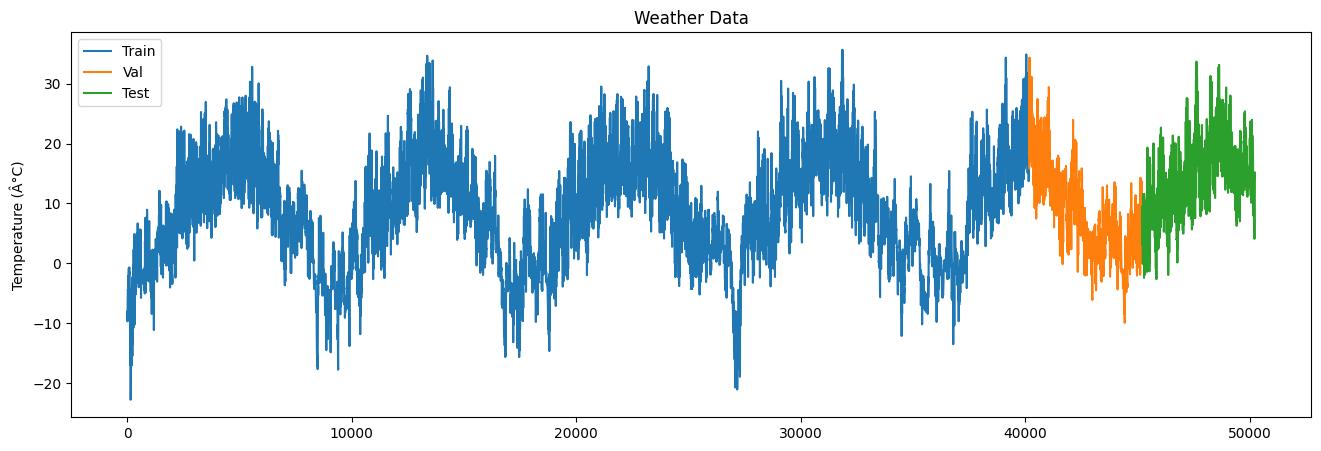

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/4
157/157 - 122s - 780ms/step - loss: 0.0896 - val_loss: 0.0490 - learning_rate: 2.8000e-04
Epoch 2/4
157/157 - 98s - 625ms/step - loss: 0.0501 - val_loss: 0.0390 - learning_rate: 2.8000e-04
Epoch 3/4
157/157 - 67s - 425ms/step - loss: 0.0418 - val_loss: 0.0321 - learning_rate: 2.8000e-04
Epoch 4/4
157/157 - 51s - 327ms/step - loss: 0.0362 - val_loss: 0.0281 - learning_rate: 2.8000e-04


c:\Sevann\UBA\LSMT-weather\univariado_unistep\plotter_class.ipynb:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  "            self.ax.set_ylabel(ylabel)\n",


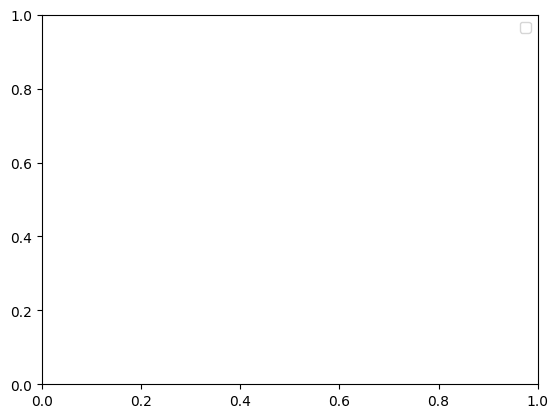

RMSE Comparison:
  RMSE Train: 0.029
  RMSE Val: 0.027
  RMSE Test: 0.032


ValueError: x and y must be the same size

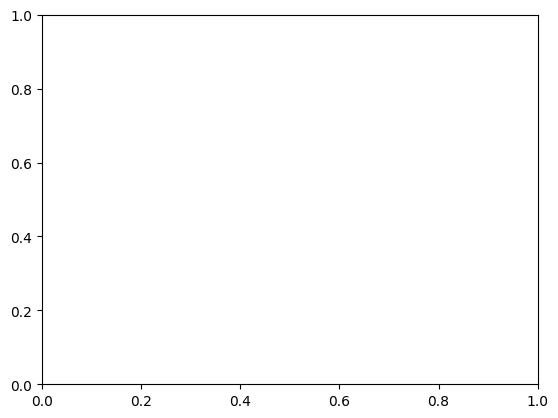

In [3]:
# Pipeline Execution
pipeline = WeatherForecastingPipeline(config)
pipeline.run()